In [1]:
# fix python path if working locally
from helpers import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

import requests
import io
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import datetime as dt

from darts import TimeSeries
from darts.models import (
    BlockRNNModel,
)
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [2]:
# Importing Training Set
def loadDataset(url):
    s=requests.get(url).content
    dataset = data=pd.read_csv(io.StringIO(s.decode('utf-8')))
    dataset.livingroom_window_open = dataset.livingroom_window_open.replace({True: 1, False: 0})
    dataset.livingroom_door_open = dataset.livingroom_window_open.replace({True: 1, False: 0})
    dataset.balcony_door_open = dataset.livingroom_door_open.replace({True: 1, False: 0})
    dataset.kitchen_window_open = dataset.kitchen_window_open.replace({True: 1, False: 0})
    dataset.timestamp = pd.Series([dt.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ') for date in list(dataset['timestamp'])]).round("10S")

    # Select features (columns) to be involved intro training and predictions
    cols = ["timestamp", "co2", "livingroom_window_open", "livingroom_door_open", "balcony_door_open", "kitchen_window_open", "rtemperature", "rhumidity", "temperature_outdoor", "humidity_outdoor"]
    return dataset[cols].drop_duplicates(subset=['timestamp'], keep='last')

dataset = loadDataset("https://iaq-data.brgr.rocks/full.csv")
print(dataset.tail)

<bound method NDFrame.tail of                  timestamp     co2  livingroom_window_open  \
0      2022-05-03 16:12:40  606.62                       0   
1      2022-05-03 16:12:50  605.24                       0   
2      2022-05-03 16:13:00  604.32                       0   
3      2022-05-03 16:13:10  604.82                       0   
4      2022-05-03 16:13:20  606.36                       0   
...                    ...     ...                     ...   
669038 2022-07-31 03:59:50  861.67                       0   
669039 2022-07-31 04:00:00  863.51                       0   
669040 2022-07-31 04:00:10  862.26                       0   
669041 2022-07-31 04:00:20  862.43                       0   
669042 2022-07-31 04:00:30  862.97                       0   

        livingroom_door_open  balcony_door_open  kitchen_window_open  \
0                          0                  0                    0   
1                          0                  0                    0   
2        

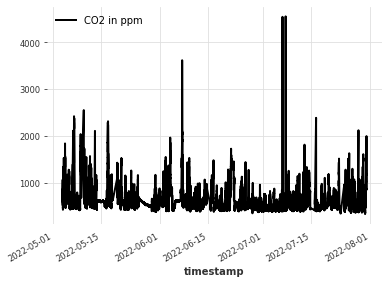

In [3]:
# series to predict, in this case CO2
series_co2 = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'co2', fill_missing_dates=True, freq="10s" ), fill='auto')

# covariates to help predict the CO2 series
covariates_livingroom_door_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_door_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_balcony_door_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'balcony_door_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_livingroom_window_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_window_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_kitchen_window_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'kitchen_window_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_temperature_indoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'rtemperature', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_humidity_indoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'rhumidity', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_temperature_outdoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'temperature_outdoor', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_humidity_outdoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'humidity_outdoor', fill_missing_dates=True, freq="10s"), fill='auto')

series_co2.plot(label="CO2 in ppm")
plt.legend()

In [4]:
scaler = Scaler()
series_co2_scaled = scaler.fit_transform(series_co2)
covariates_livingroom_door_open_scaled, covariates_balcony_door_open_scaled, covariates_livingroom_window_open_scaled, covariates_kitchen_window_open_scaled, covariates_temperature_indoors_scaled, covariates_humidity_indoors_scaled, covariates_temperature_outdoors_scaled, covariates_humidity_outdoors_scaled = scaler.fit_transform([covariates_livingroom_door_open, covariates_balcony_door_open, covariates_livingroom_window_open, covariates_kitchen_window_open, covariates_temperature_indoors, covariates_humidity_indoors, covariates_temperature_outdoors, covariates_humidity_outdoors])

In [5]:
train_split = 720000
test_split = len(series_co2_scaled)-train_split
print(test_split)

# training data
train_series_co2 = series_co2_scaled[:train_split]
train_covariates_livingroom_door_open = covariates_balcony_door_open_scaled[:train_split]
train_covariates_balcony_door_open = covariates_balcony_door_open_scaled[:train_split]
train_covariates_livingroom_window_open = covariates_livingroom_window_open_scaled[:train_split]
train_covariates_kitchen_window_open = covariates_kitchen_window_open_scaled[:train_split]
train_covariates_temperature_indoors = covariates_temperature_indoors_scaled[:train_split]
train_covariates_humidity_indoors = covariates_humidity_indoors_scaled[:train_split]
train_covariates_temperature_outdoors = covariates_temperature_outdoors_scaled[:train_split]
train_covariates_humidity_outdoors = covariates_humidity_outdoors_scaled[:train_split]
train_covariates = train_covariates_livingroom_door_open.stack(train_covariates_balcony_door_open).stack(train_covariates_livingroom_window_open).stack(train_covariates_kitchen_window_open).stack(train_covariates_temperature_indoors).stack(train_covariates_humidity_indoors).stack(train_covariates_temperature_outdoors).stack(train_covariates_humidity_outdoors)

# test data
test_series_co2 = series_co2_scaled[-test_split:]
test_covariates_livingroom_door_open = covariates_balcony_door_open_scaled[-train_split:]
test_covariates_balcony_door_open = covariates_balcony_door_open_scaled[-train_split:]
test_covariates_livingroom_window_open = covariates_livingroom_window_open_scaled[-train_split:]
test_covariates_kitchen_window_open = covariates_kitchen_window_open_scaled[-train_split:]
test_covariates_temperature_indoors = covariates_temperature_indoors_scaled[-train_split:]
test_covariates_humidity_indoors = covariates_humidity_indoors_scaled[-train_split:]
test_covariates_temperature_outdoors = covariates_temperature_outdoors_scaled[-train_split:]
test_covariates_humidity_outdoors = covariates_humidity_outdoors_scaled[-train_split:]
test_covariates = test_covariates_livingroom_door_open.stack(test_covariates_balcony_door_open).stack(test_covariates_livingroom_window_open).stack(test_covariates_kitchen_window_open).stack(test_covariates_temperature_indoors).stack(test_covariates_humidity_indoors).stack(test_covariates_temperature_outdoors).stack(test_covariates_humidity_outdoors)

44568


In [12]:
model_co2 = BlockRNNModel(
    model="GRU",
    input_chunk_length=90,
    output_chunk_length=90,
    batch_size=90,
    n_epochs=30,
    random_state=0,
    dropout=0.1,
    model_name="GRU",
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "gpus": [0]
    },
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    force_reset=True,
)

In [25]:
model_co2.fit(series=train_series_co2, past_covariates=train_covariates, verbose=True)

2022-07-31 12:40:30 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 719821 samples.
2022-07-31 12:40:30 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: True
2022-07-31 12:40:30 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-31 12:40:30 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-07-31 12:40:30 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-07-31 12:40:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-07-31 12:40:30 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 2.7 K 
4 | fc            | Sequential 

Training: 0it [00:00, ?it/s]

In [26]:
model_co2.save_model('co2_gru_90x90x50.pth.tar')